In [1]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from Visualisations import HeatmapVisualizer
import numpy as np

In [14]:
df_raw = pd.read_excel("output/politiedemo-100-30-1/resampled_df_10_min.xlsx", index_col=[0])

start_date = pd.to_datetime(f"2023-05-10 00:00:00")
end_date = pd.to_datetime(f"2023-09-10 23:50:00")
model_features = ["hour", "weekday", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

df = df_raw[df_raw["timestamp"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

df["weekday"] = df["timestamp"].dt.dayofweek
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["window_block"] = ((df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second) // 600).astype(int)

train_start_date = start_date + pd.Timedelta(days=0)
train_end_date = train_start_date + pd.Timedelta(days=6, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=6, hours=23, minutes=50)

train_mask = df["timestamp"].between(train_start_date, train_end_date)
test_mask = df["timestamp"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")


Training: 2023-05-10 00:00:00-2023-05-16 23:50:00, testing: 2023-05-17 00:00:00-2023-05-23 23:50:00.


In [21]:
df.head()

,timestamp,location,weekday,hour,day,window_block
720,2023-05-10 00:00:00,"20, Lokerenpassage",2,0,10,0
721,2023-05-10 00:10:00,"20, Lokerenpassage",2,0,10,1
722,2023-05-10 00:20:00,"20, Lokerenpassage",2,0,10,2
723,2023-05-10 00:30:00,"20, Lokerenpassage",2,0,10,3
724,2023-05-10 00:40:00,"20, Lokerenpassage",2,0,10,4


In [15]:
model = RandomForestClassifier()
model.fit(X_train, y_train) # , sample_weight=np.linspace(0, 1, len(X_train))

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [16]:
for d in range(7):
    # Then, evaluate the baseline's predictions and store acc in self.baseline_performance
    this_day_predictions = predictions[d*144:(d+1)*144]
    this_day_actual_values = y_test[d*144:(d+1)*144]
    acc = accuracy_score(this_day_actual_values, this_day_predictions)
    print(f"Acc for day {d}: {acc}")

Acc for day 0: 0.7986111111111112
Acc for day 1: 0.8402777777777778
Acc for day 2: 0.5069444444444444
Acc for day 3: 0.125
Acc for day 4: 0.6527777777777778
Acc for day 5: 0.7152777777777778
Acc for day 6: 0.8611111111111112


Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-05-10T00:00:00.000000000 and ending at 2023-05-16T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/test/heatmap_training.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-05-17T00:00:00.000000000 and ending at 2023-05-23T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/test/heatmap_predicted.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-05-17T00:00:00.000000000 and ending at 2023-05-23T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/test/heatmap_actual.png.


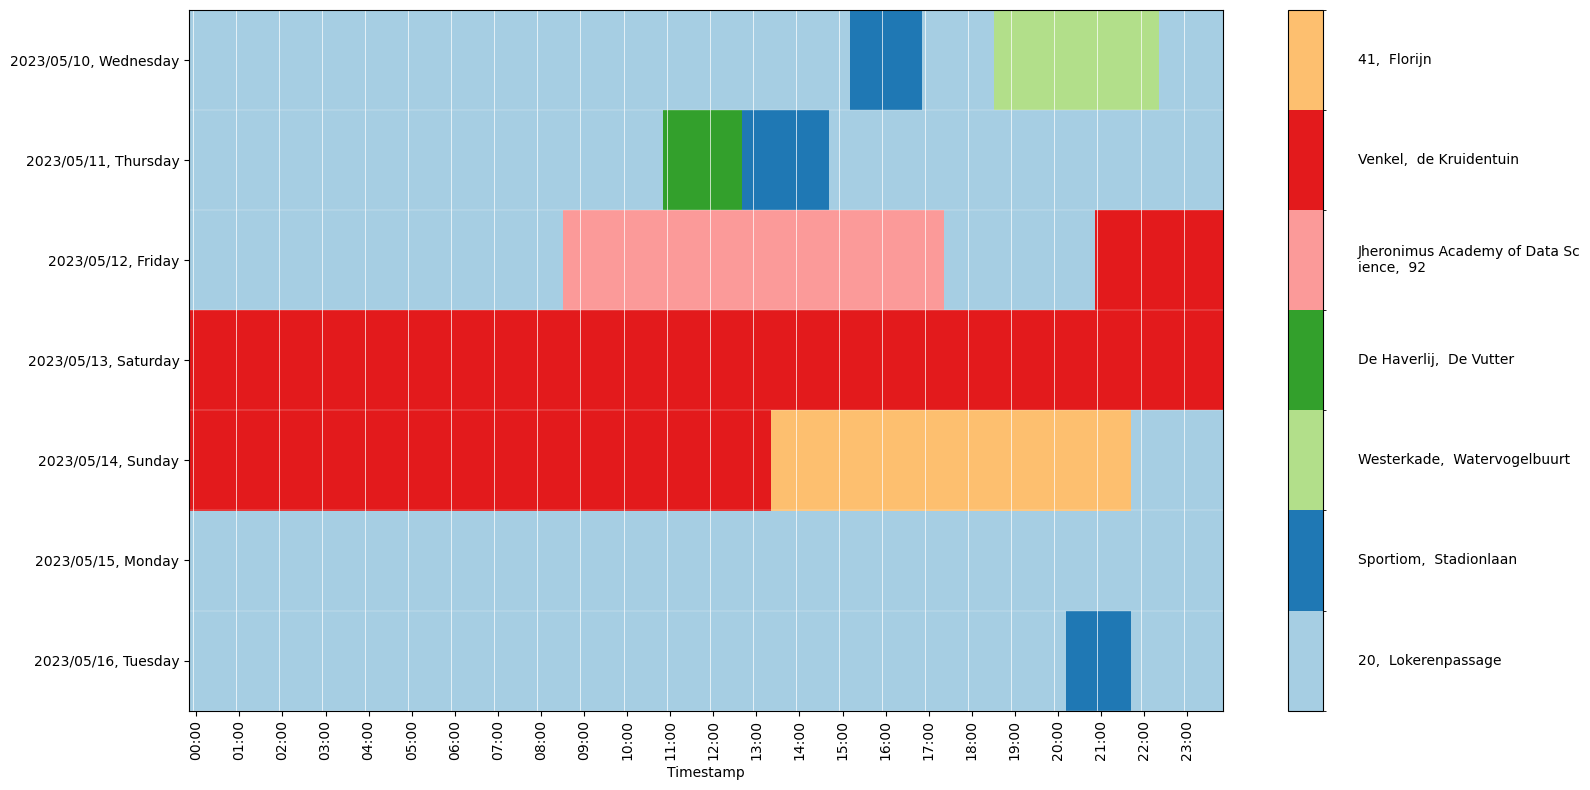

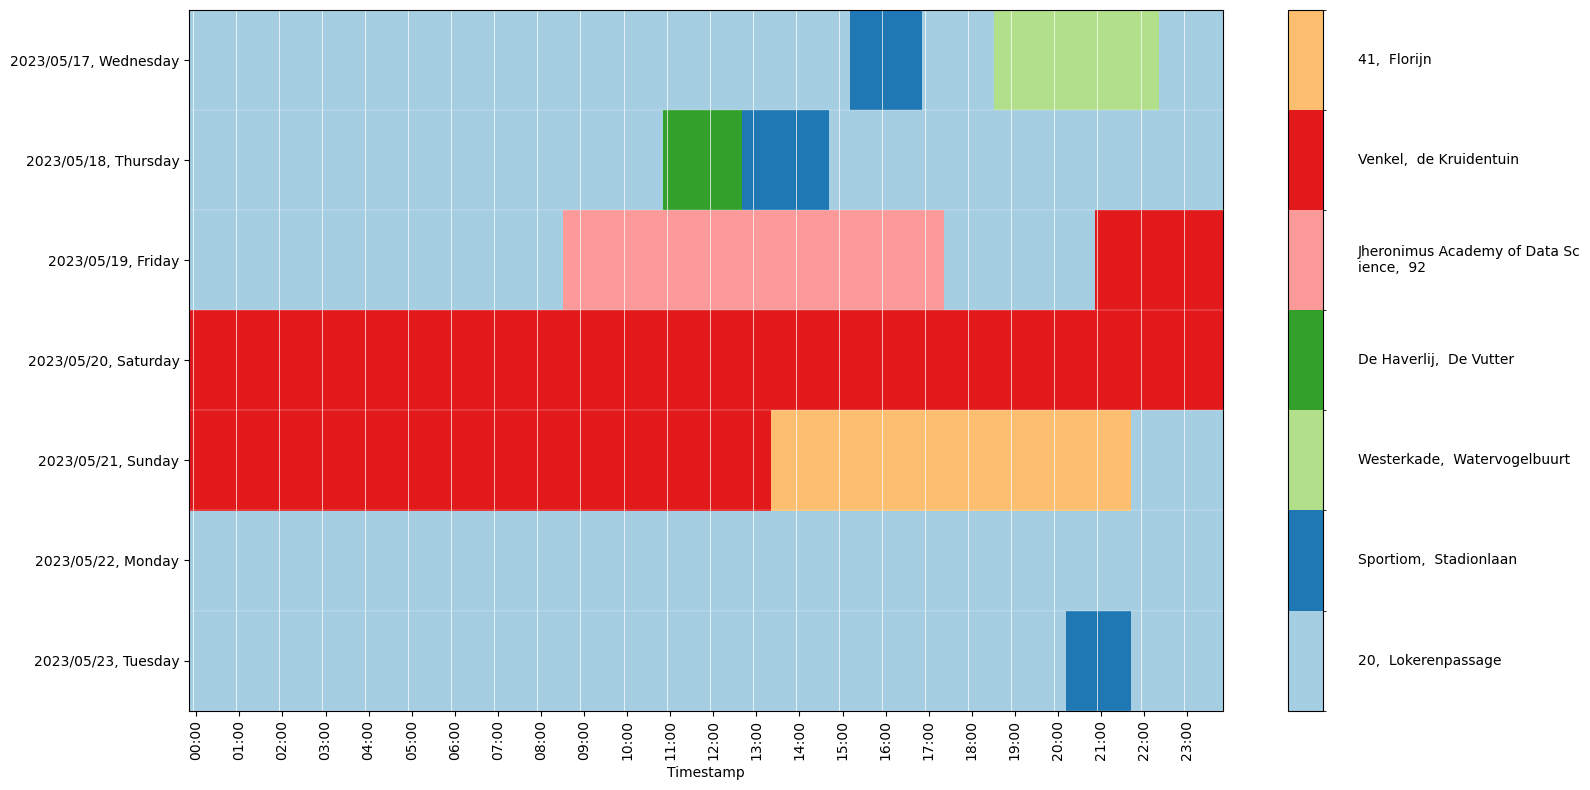

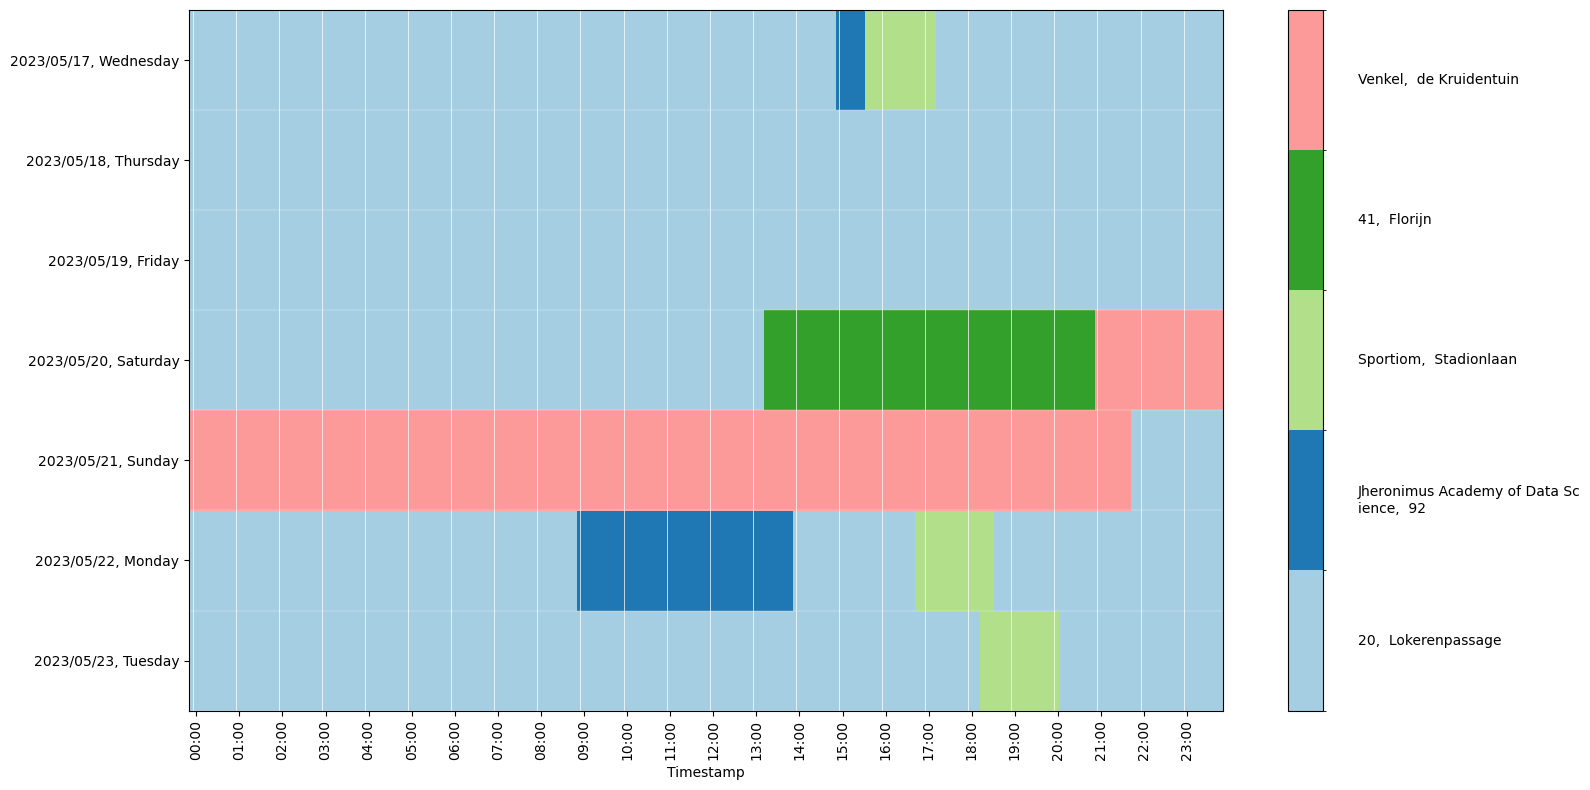

In [17]:
df.location = label_encoder.inverse_transform(df.location)

time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "timestamp": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "timestamp"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    outputs_folder_name="test",
    name="heatmap_training",
    title="TRAINING",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    outputs_folder_name="test",
    name="heatmap_predicted",
    title="PREDICTIONS",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "timestamp"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    outputs_folder_name="test",
    name="heatmap_actual",
    title="ACTUAL",
)

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Load your dataset into a DataFrame
# Replace this with your actual DataFrame
data = df.copy()

# Encode the 'location' column
label_encoder = LabelEncoder()
data['location'] = label_encoder.fit_transform(data['location'])

# Define your input features and target variable
X = data[['weekday', 'hour', 'day', 'window_block']]
y = data['location']

In [26]:
# Normalize the input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [30]:
# Specify the ratio for training and testing data
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [32]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predicted labels
y_pred = label_encoder.inverse_transform(np.round(y_pred).astype(int))

# Print the predicted labels
print('Predicted labels:')
print(y_pred)

Epoch 1/5
14284/14284 - 18s - loss: 8.7740 - 18s/epoch - 1ms/step
Epoch 2/5
14284/14284 - 15s - loss: 8.4914 - 15s/epoch - 1ms/step
Epoch 3/5
14284/14284 - 15s - loss: 8.4818 - 15s/epoch - 1ms/step
Epoch 4/5
14284/14284 - 14s - loss: 8.4557 - 14s/epoch - 999us/step
Epoch 5/5
14284/14284 - 14s - loss: 8.4303 - 14s/epoch - 966us/step
112/112 [==============================] - 0s 944us/step - loss: 6.5228
Test loss: 6.5228
112/112 [==============================] - 0s 856us/step
Predicted labels:
[' ASML,  De Run 6200' ' ASML,  De Run 6200' ' ASML,  De Run 6200' ...
 ' Beukenlaan,  Waalre' ' Beukenlaan,  Waalre' ' Beukenlaan,  Waalre']


c:\Users\Sander\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
y_pred

array([' ASML,  De Run 6200', ' ASML,  De Run 6200',
       ' ASML,  De Run 6200', ..., ' Beukenlaan,  Waalre',
       ' Beukenlaan,  Waalre', ' Beukenlaan,  Waalre'], dtype=object)

In [35]:
label_encoder.inverse_transform(np.round(y_test).astype(int))

array([' 41,  Florijn', ' 41,  Florijn', ' 41,  Florijn', ...,
       ' Jheronimus Academy of Data Science,  92',
       ' Jheronimus Academy of Data Science,  92',
       ' Jheronimus Academy of Data Science,  92'], dtype=object)

In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

In [ ]:
print(f"Acc random forest classifier: {accuracy_score(y_test, predictions)}")
print(f"Acc dummy model: {accuracy_score(y_test, dummy_predictions)}")

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, dummy_predictions, labels=dummy_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_model.classes_)
disp.plot()
plt.show()